<h1 style="font-family: monospace; color: orange; text-align: center; font-size: 50px;"> 
    Poker Player Patterns
</h1><br />

The data needed is [here](https://www.kaggle.com/smeilz/poker-holdem-games#Export%20Holdem%20Manager%202.0%2012292016131233.txt), specific file used is 
<span style="color: black; color: FireBrick; font-weight: bold;">
    Export Holdem Manager 2.0 12302016144830.txt
</span>.
<br />
It represents a game of over 40 000 rounds played on a table with real money (prbbly in dolars).

## Environment settings
We will use a couple of libraries, with outside dependancies being matplotlib, networkx and pandas. From our library we will require only the enums, as they identify some ids included in the csv files.

In [196]:
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from lib import ActionId, TurnId

# rounds gathered (last one is not finished)
MAX_ROUND = 42688 - 1
# user that provided the data (sometimes deviates highly)
MAIN_USER = 'IlxxxlI'

nrowdisplay = 10
max_round = MAX_ROUND
pd.options.display.max_rows = nrowdisplay

# monkeypatch ungroup to pandas
pd.core.frame.DataFrame.ungroup = (
    lambda self: self.reset_index().drop(
        columns = ['level_0', 'level_1', 'level_2'],
        errors = 'ignore'
    )
)

# default ax configuration
def setAxConfig(ax, title, xlab, ylab):
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_alpha(0.5)
    ax.spines['bottom'].set_alpha(0.5)
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

## Load csv
Here we load the parsed and later tidied data. <br />
Because there are many files and we have to do similar things for each one, there is a loop that takes care of all and also reduces readability. <br />
We will often combine columns of different data frames without merging them by 
<span style="font-family: monospace;">user_id</span> column, therefore we must sort them (all users are accounted for as we made sure when the data was tidied).

In [197]:
load_path = Path.cwd() / 'tidy_data'

for file in load_path.iterdir():
    data = pd.read_csv(file)
    if 'round_id' in data.columns:
        data = data[data.round_id <= max_round]
    if 'user_id' in data.columns:
        data = data.sort_values('user_id')
    globals()[file.stem] = data

user_dict = list(user_ids.user)
main_user_id = user_dict.index(MAIN_USER)

## Card Strength
Here we will evaluate strength of a specific card combination in multiple ways.<br />
That will include checking how many times and how much user has won when dealt a specific card.

In [200]:
card_wins = received_cards.merge(
    cardshow[cardshow.user_id == 5], 
    'outer', 'round_id'
).dropna().groupby(
    ['card1', 'card2']
).apply(
    lambda df: pd.DataFrame(
        data = {
            'avg_won': [df.amount.mean()],
            'times_won': [sum(df.amount > 0)]
        }
    )
).ungroup().sort_values(
    by = ['avg_won', 'times_won'], 
    ascending = False
)

In [202]:
card_wins.head(10)

,card1,card2,avg_won,times_won
1235,A♥,A♦,10.289474,33
1281,J♥,J♦,7.145714,25
1300,K♠,K♦,6.827674,34
1206,A♠,A♣,6.728049,35
1323,Q♣,Q♥,5.813750,28
1324,Q♣,Q♦,5.638261,21
1311,K♥,K♦,5.502414,24
1255,A♦,K♦,5.296538,24
1131,8♦,K♦,4.373793,7
1320,Q♠,Q♣,4.371143,32


In [203]:
card_wins.tail(10)

,card1,card2,avg_won,times_won
302,2♥,5♥,-2.280937,5
1251,A♦,J♦,-2.290541,20
1173,9♥,9♦,-2.497931,16
1301,K♠,Q♠,-2.559667,17
193,10♦,K♦,-2.608462,17
1298,K♠,K♣,-3.510789,28
1052,8♠,8♦,-3.831154,11
1299,K♠,K♥,-3.999333,35
754,5♣,J♣,-4.099167,2
1254,A♦,K♥,-4.227879,25


What we notice here is that while AA and KK is usually the winning combo, KK is also on the bottom as it probably aspires too much confidence. In fact there are many good combinations on the top, which makes sense as most money is lost with good hands.

Lets now visualise the correlation between the number of times won by a card combination and the winning average while coloring the <span style="color:FireBrick;">paired combinations</span> (colors with more opacity represent pairs with highest values). We should expect a positive correlation.

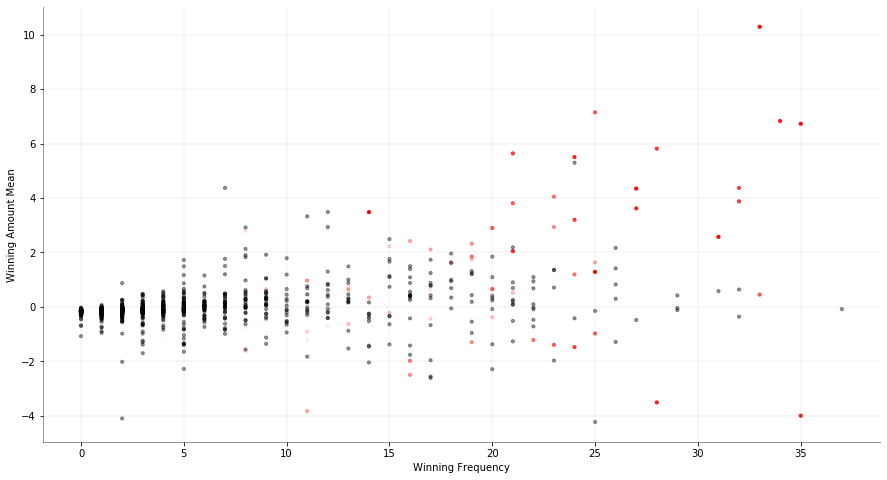

In [204]:
pair_cmap = dict(zip(
    list(map(str, range(2, 11))) + list('JQKA'),
    [(1, 0, 0, pow((i+1), 2) / 169) for i in range(13)]
))
pair_colors = [
    pair_cmap[c1[:-1]] if c1[:-1] == c2[:-1] else (0,0,0,0.4)
    for c1, c2 in zip(card_wins.card1, card_wins.card2)
]

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
setAxConfig(ax, '', 'Winning Frequency', 'Winning Amount Mean')
ax.scatter(
    card_wins.times_won, card_wins.avg_won,
    s = 10, c = pair_colors
);

It's kind of interesting that winning more often by a hand does not substentially bring more profit. It shows that playing with a high pair pays off as the mean values really show up high. Next we'll try to show which exact values work best when paired. We will connect 

In [205]:
value_connections = card_wins.apply(
    lambda row: pd.Series([
        row.card1[:-1], row.card2[:-1],
        row.avg_won, row.times_won
    ], index = ['val1', 'val2',  'avg_won', 'times_won']), 
    axis = 1, result_type = 'expand'
).groupby(
    ['val1', 'val2']
).apply(
    lambda df: pd.DataFrame(
        data = {
            'avg_won': [df.avg_won.mean()],
            'times_won': [df.times_won.sum()]
        }
    )
).ungroup()

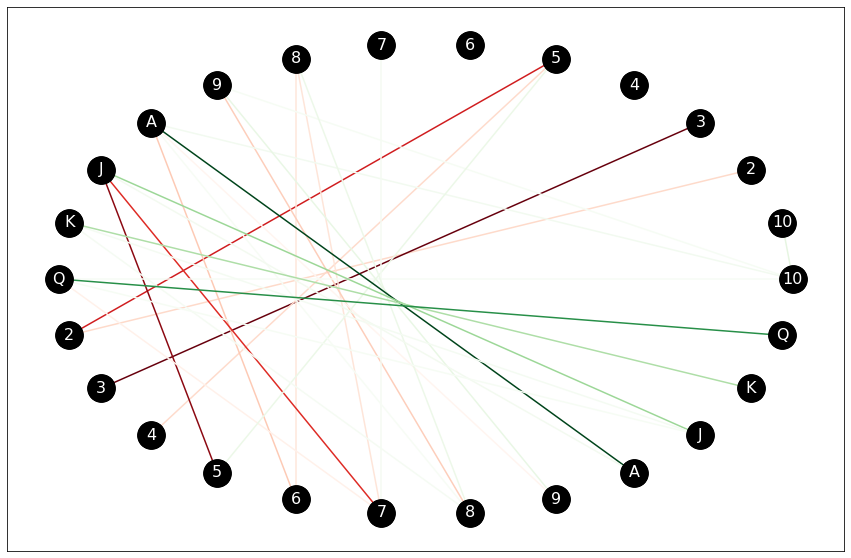

In [271]:
m, M = [abs(f(value_connections.avg_won)) for f in [min, max]]

index_map = dict(zip(
    list(map(str, range(2, 11))) + list('JQKA'),
    range(13)
))

G = nx.Graph()
for i, row in value_connections.iterrows():
    i1 = index_map[row.val1]
    i2 = index_map[row.val2] + 13
    G.add_nodes_from([i1, i2])
    if abs(row.avg_won) > 0.2:
        norm = M if row.avg_won > 0 else m 
        color = 'green' if row.avg_won > 0 else 'red'
        G.add_edge(
            i1, i2, color = color,
            cmap = abs(row.avg_won) / norm
        )
    
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
layout = nx.circular_layout(G)

for color, cm in zip(
    ['red', 'green'], [plt.cm.Reds, plt.cm.Greens]
):
    edges = [
        edge for edge in G.edges
        if G.edges.get(edge)['color'] == color
    ]
    nx.drawing.nx_pylab.draw_networkx(
        G, layout, 
        node_color='black', node_size=750,
        edgelist=edges, edge_color = [
            G.edges.get(edge)['cmap'] 
            for edge in edges
        ],
        width=1.5, edge_cmap=cm
    )

nx.nx.drawing.nx_pylab.draw_networkx_labels(
    G, layout, dict(zip(
        range(26), 
        list(index_map.keys()) * 2
    )), 
    font_size = 16, font_color = 'white'
);

It seems as playing high pairs is a profitable strategy, while playing Jacks with a low value doesn't seem like a great idea.

## Player Pattern Correlations
We'll gather some basic information about the players and show some correlations. These will serve us as a rough insight into players' general behaviour. In this section we will treat bets as raises as they actually are raises in some form.

### Folds and Raises vs. Winnings
We will check if the fold average of a player has any effect on his winnings. <br />
This is a rough estimate of player's low agression level, which we will analyse later on.

In [140]:
def actionSummary(df):
    count = Counter(df.action_id)
    return {
        action.name: [count[int(action)]]
        for action in ActionId
    }
        
action_summary = actions.groupby('user_id').apply(
    lambda df: pd.DataFrame(
        data = {
            **actionSummary(df),
            'all_actions': [len(df.action_id)]
        }
    )
).ungroup()

In [141]:
winnings = cardshow.groupby('user_id').apply(
    lambda df: pd.DataFrame(
        data = {
            'total_won': [df.amount.sum()],
            'mean_won': [df.amount.mean()]
        }
    )
).ungroup()

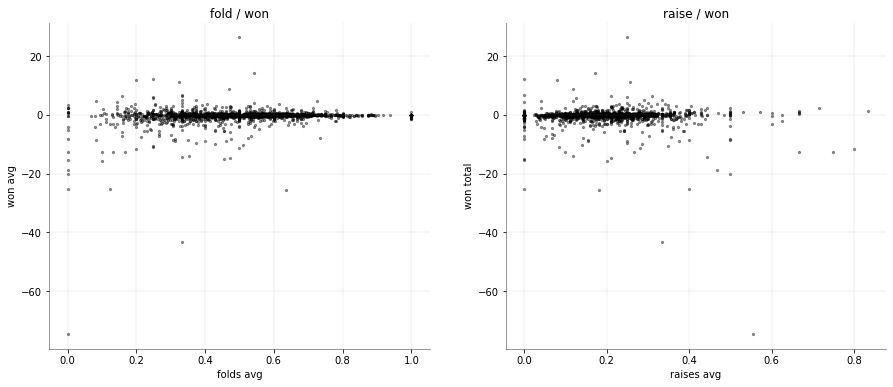

In [142]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
setAxConfig(ax1, 'fold / won', 'folds avg', 'won avg')
setAxConfig(ax2, 'raise / won', 'raises avg', 'won total')

temp_act = action_summary[action_summary.user_id != main_user_id]
temp_won = winnings[winnings.user_id != main_user_id]

ax1.scatter(
    temp_act.FOLD / temp_act.all_actions, 
    temp_won.mean_won,
    s=5, c='black', alpha=0.4
)
ax2.scatter(
    (temp_act.RAISE + temp_act.BET) / temp_act.all_actions,
    temp_won.mean_won, 
    s=5, c='black', alpha=0.4
);

We see here that folding more often stabilizes relative winnings a bit, which makes sense as folding 99% of the time doesn't keeps the variance pretty still. Other than that there is no real correlation here.

### Raises vs. Raise Amount
Here we will check the correlation between players' raise frequency and raise amount.
We assume players who raise more frequently raise more as they are generally more agressive.

In [143]:
raise_stats = actions.groupby('user_id').apply(
    lambda df: pd.DataFrame(
        data = {
            'avg_raise': [
                df[
                    (df.action_id == ActionId.RAISE) |
                    (df.action_id == ActionId.BET)
                ].amount.mean()
            ]
        }
    )
).ungroup()
raise_stats.avg_raise = raise_stats.avg_raise.replace(pd.NaT, 0)

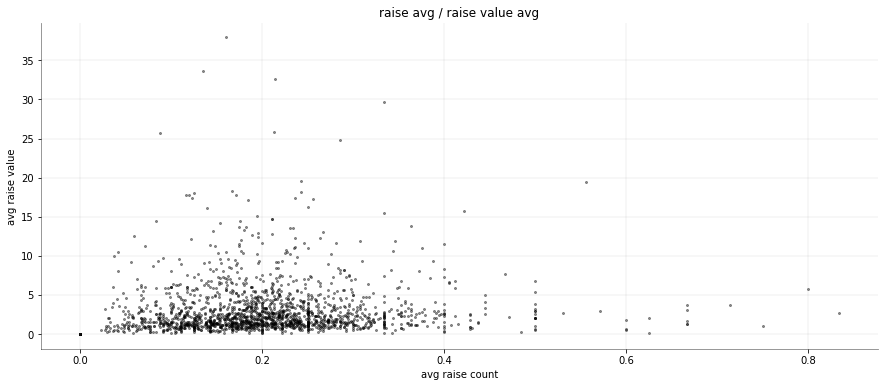

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
setAxConfig(ax, 'raise avg / raise value avg', 'avg raise count', 'avg raise value')
ax.scatter(
    (temp_act.RAISE + temp_act.BET) / temp_act.all_actions,
    raise_stats.avg_raise[raise_stats.user_id != main_user_id], 
    s=4, c='black', alpha=0.4
);

Our speculation proved to be correct as there really is a slight positive correlation.